<!--HEADER-->
*[Guia de aulas da disciplina de Modelagem Matemática](https://github.com/rmsrosa/modelagem_matematica) do [IM-UFRJ](https://www.im.ufrj.br).*

<!--NAVIGATOR-->

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/09.00-Aula9.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>
&nbsp;
<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/09.00-Aula9.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>
&nbsp;
<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/09.00-Aula9.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;

[<- Aula 8: O pendulo com angulos grandes, um pouco de EDO e simulacoes](08.00-Aula8.ipynb) | [Página Inicial](00-Sumario.ipynb) 

---


# Aula 9: Pêndulo via deteção de movimento

## Objetivos

- Capturar o traçado de um pêndulo a partir de um vídeo
- Transformar o traçado na representação $\theta(t)$ da posição do pêndulo.
- Fazer o ajuste do modelo de EDO a esses dados.
- Examinar a dependência do período em relação à amplitude do ângulo de oscilação.

### Importando as bibliotecas necessárias

In [1]:
from os import path, listdir, getcwd
import sys
import io, base64

import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, HTML

videos_dir = path.join('..', 'dados', 'pendulo_movimento')

## Módulo de detecção e traçamento do movimento

O módulo python de detecção de movimento foi feito com base no código descrito na página [Basic motion detection and tracking with Python and OpenCV](https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/). 

Esse código utiliza o pacote [OpenCV](https://pypi.org/project/opencv-python/) do python e ferramentas de manipulação de imagens do próprio autor do script, contidas no pacote [imutils](https://www.pyimagesearch.com/2015/02/02/just-open-sourced-personal-imutils-package-series-opencv-convenience-functions/) (disponível em [github/jrosebr1/imutils](https://github.com/jrosebr1/imutils) e em [PyPI - imutils](https://pypi.org/project/imutils/)).

### Mais informaçõs sobre OpenCV

Outro script que usa apenas o `opencv` é [WebCam Motion Detector in Python](https://www.geeksforgeeks.org/webcam-motion-detector-python/).

Outras páginas com exemplos e explicações intessantes: [Read, Write and Display a video using OpenCV ( C++/ Python )](https://www.learnopencv.com/read-write-and-display-a-video-using-opencv-cpp-python/), [Webcam based image processing in iPython notebooks](https://medium.com/@neotheicebird/webcam-based-image-processing-in-ipython-notebooks-47c75a022514).

Para a manipulação de imagens, veja [How to Load and Manipulate Images for Deep Learning in Python With PIL/Pillow](https://machinelearningmastery.com/how-to-load-and-manipulate-images-for-deep-learning-in-python-with-pil-pillow/).

Sobre *thresholding* para a detecção de objetos, veja [Image Thresholding](https://docs.opencv.org/4.0.1/d7/d4d/tutorial_py_thresholding.html).

Sobre superposição de textos com acentos (unicode) no vídeo processado, veja [Load TrueType Font to OpenCV](https://stackoverflow.com/questions/37191008/load-truetype-font-to-opencv/46558093#46558093), [How to use unicode characters with PIL?](https://stackoverflow.com/questions/18942605/how-to-use-unicode-characters-with-pil/22612295#22612295)

A página [OpenCV](https://pypi.org/project/opencv-python/) contém as informações para a instalação do *opencv* no python, via pip. Como mencionado lá, observe que há várias versões que usam o mesmo *namespace* `cv2`, e apenas uma delas deve ser utilizada.

No meu sistema, instalei
```bash
pip install opencv-contrib-python
pip install imutils
```

No ambiente do Google Colab, os pacotes `cv2` e `imutils` já estão presentes.

No binder, basta incluir esses pacotes no arquivo `requirements.txt` do repositório que o binder monta o ambiente com esses pacotes.

## O código original

O código original `motion_detector.py` na página [Basic motion detection and tracking with Python and OpenCV](https://www.pyimagesearch.com/2015/05/25/basic-motion-detection-and-tracking-with-python-and-opencv/) abre três janelas de vídeo e, por conta dessas janelas, não funciona dentro do Jupyter.

Fiz modificações para ele funcionar como um módulo a ser importado pelo Jupyter.

## Modificando o script para criar um módulo

### Modificação inicial

Essencialmente, passei a essência do código `motion_detector.py` para uma função dentro de um módulo e deixei as constantes para serem passadas como parâmetros para essa função.

Também incluí um `if __name__ == '__main__':` para possibilitar executar o módulo como um script, passando os devidos argumentos.

### Adicionando opção para gravar um vídeo de saida com o traçamento do objeto

Incluí uma opção de gravar vídeos com o resultado da deteção e com as outras imagens utilizadas no processamento. Alguns detalhes:

- Uma questão é que é preciso configurar as dimensões do arquivo de saída com sendo iguais às dos quadros tratados. Vi como ler esses dados do primeiro quadro, usando 
```python 
height, width, channels = frame.shape
````
e, assim, inicializar o arquivo de gravação.

- Outra questão é que o opencv não estava gravando ou então estava gravando em um formato que o QuickTime não estava lendo. Algum problema de configuração. Achei a resposta no link [openCV video saving in python](https://stackoverflow.com/questions/29317262/opencv-video-saving-in-python). Basta configurar 
```python
fourcc = cv2.VideoWriter_fourcc(*'MJPG')
``` 
e usar isso na linha de inicialização do arquivo de saída: 
```python
out = cv2.VideoWriter('output.avi', fourcc, 20.0, (width,height))
```

### Capturando as coordenadas do movimento

No código original, o movimento é apenas exibido em um vídeo. 

Modifiquei-o para guardar esse movimento em uma lista, contendo o número de cada **quadro** analisado e os dados espaciais da **caixa de entorno** do objeto em movimento, no quadro em questão. 

Os dados da caixa de entorno contém as coordenadas **horizontal** e **vertical** (em pixels) do canto superior esquerdo da caixa (retângulo) que contém o objeto detectado, seguidas da **largura** e da **altura** da caixa.

**Observação:** É importante ressaltar, na intepretação do resultado, que o ponto de coordenada $(0,0)$ corresponde ao canto superior esquerdo.

### Importando o módulo

Primeiro, verifico o diretório do módulo.

In [2]:
listdir(path.join('..', 'codigos', 'deteccao_de_movimento'))

['.ipynb_checkpoints', '__pycache__', 'movimento.py']

Em seguido, adiciono este caminho ao PATH e importo o módulo

In [3]:
sys.path.insert(0, path.abspath(path.join(getcwd(),'..', 'codigos', 'deteccao_de_movimento')))

import movimento

### Ajuda do módulo

In [4]:
help(movimento)

Help on module movimento:

NAME
    movimento - Detecção e traçamento do movimento de objetos em vídeos.

DESCRIPTION
    Este código possui uma função de detecção e traçamento do 
    movimento de objetos em vídeos. 
    
    O código identifica objetos se movendo e enquadra o objeto com uma
    "caixa de entorno". Para cada quadro em que um objeto em movimento,
    o número do quadro, junto com os dados dessa caixa de entorno 
    (coordenadas horizontal e vertical do canto inferior da caixa e a 
    largura e a altura da caixa) são registrados em uma lista. Essa 
    lista é retornada pela função ao final da análise.
    
    Isso é implementado por uma única função, que possui outros argumentos
    de configuração e funcionalidades:
    
        * detector_de_movimento: recebe o caminho para um arquivo de video
            que será analisado visando detectar e traçar o movimento de um 
            ou mais objetos. 
            
            Retorna o número de quadros por segundo do

## Sobre o método de captura do movimento

A captura do movimento é feita através de um simples método de contraste com a imagem do primeiro quadro do filme. Os seguintes passos são feitos:

- O primeiro quadro do filme é transformado em escala de cinza (de 0 a 255, i.e. de preto a branco), gerando um quadro denominado `firstFrame`.

- Cada quadro subsequente também é transformado em escala de cinza (denominado `gray`) e um novo quadro é formado com a diferença entre esse quadro e o primeiro quadro: `tresh = gray - firstFrame`.

- Com base em um `nivel_de_cinza`, entre 0 e 255, essa diferença é transformada em uma imagem `tresh` em preto e branco, ficando cada *pixel* preto, se o cinza estiver abaixo desse nível, ou branco, se estiver acima.

- Curvas de contorno entre as partes em preto e em branco da imagem `tresh` são identificadas pelo `opencv`.

- Para cada curva envolvendo uma área maior do que uma área mínima `area_min`, uma *caixa de entorno* é registrada.

### Versão curta do primeiro vídeo do pêndulo

Vamos começar com o vídeo `pendulo_70cm_1_trecho.mov`, que exibe apenas um trecho inicial, de uns 4 segundos, do vídeo `pendulo_70cm_1_reduzido.mov`, que tem 16 segundos. O termo `reduzido` se refere a reduções na resolução e na qualidade do vídeo original, que é de 44Mb. O original do vídeo seguinte, com 2 minutos, tem mais de 230Mb. Por isso a necessidade dessa redução.

In [5]:
video = io.open(path.join(videos_dir, 'pendulo_70cm_1_trecho.mov'), 'r+b').read()
encoded = base64.b64encode(video)

In [6]:
HTML(data='''<video width="80%" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii')))

#### Executando o módulo: primeiro vídeo exibindo a detecção

Agora, executo o módulo neste vídeo, guardando os dados do movimento em uma variável `dados` e gravando o vídeo de saída no arquivo

In [7]:
fps, num_quadros, tracado = movimento.detector_de_movimento(path.join(videos_dir, 'pendulo_70cm_1_trecho.mov'), 
                                video_tracado=path.join(videos_dir, 'pendulo_70cm_1_trecho_com_deteccao.avi'),
                                video_cinza=path.join(videos_dir, 'pendulo_70cm_1_trecho_cinza.avi'),
                                video_pb=path.join(videos_dir, 'pendulo_70cm_1_trecho_pb.avi'))

#### Informações iniciais

In [8]:
print('Quadros por segundo:', fps)
print('Número de quadros:', num_quadros)
print(f"Tempo tratado de vídeo: {int(num_quadros/fps/60):3d}m {int(num_quadros/fps % 60):02d}s {int(1000*(num_quadros/fps % 1)):02d}ms")
print()
print('Dados iniciais do traçado:')
tracado[1:11]

Quadros por segundo: 29.97002997002997
Número de quadros: 119
Tempo tratado de vídeo:   0m 03s 970ms

Dados iniciais do traçado:


[['quadro', 'abscissa(px)', 'ordenada(px)', 'largura(px)', 'altura(px)'],
 [16, 495, 107, 17, 49],
 [17, 494, 107, 18, 51],
 [18, 493, 107, 19, 51],
 [19, 493, 107, 19, 51],
 [20, 493, 107, 19, 50],
 [21, 493, 107, 19, 51],
 [22, 493, 108, 19, 50],
 [23, 493, 108, 19, 49],
 [24, 492, 107, 20, 51]]

#### Exibindo a detecção

In [9]:
video = io.open(path.join(videos_dir, 'pendulo_70cm_1_trecho_com_deteccao.avi'), 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="80%" alt="test" controls><source src="data:video/avi;base64,{0}" type="video/avi" />
             </video>'''.format(encoded.decode('ascii')))

#### Exibindo o vídeo em escala de cinzas

In [10]:
video = io.open(path.join(videos_dir, 'pendulo_70cm_1_trecho_cinza.avi'), 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="80%" alt="test" controls><source src="data:video/avi;base64,{0}" type="video/avi" />
             </video>'''.format(encoded.decode('ascii')))

#### Exibindo vídeo do contraste em preto e branco

In [11]:
video = io.open(path.join(videos_dir, 'pendulo_70cm_1_trecho_pb.avi'), 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<video width="80%" alt="test" controls><source src="data:video/avi;base64,{0}" type="video/avi" />
             </video>'''.format(encoded.decode('ascii')))

#### Gráfico dos dados

A haste do pêndulo é de $70\,\texttt{cm}$ contados da ponta de cima do fio até a centróide da bola, considerada como sendo o centro de massa do objeto, que por sua vez é tratado como um objeto pontual.

Primeiro, lemos os dados retornados pelo traçador:

In [12]:
nd = np.array(tracado[2:])
quadro = nd[:,0]
x = nd[:,1]
y = nd[:,2]
w = nd[:,3]
h = nd[:,4]

#### Informações da coordenada horizontal

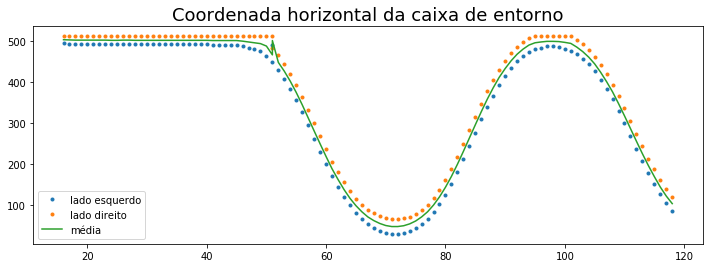

In [28]:
plt.figure(figsize=(12,4))
plt.plot(quadro, x, '.', label='lado esquerdo')
plt.plot(quadro, x+w, '.', label='lado direito')
plt.plot(quadro, x+w/2, '-', label='média')
plt.title('Coordenada horizontal da caixa de entorno', fontsize=18)
plt.legend()
plt.show()

#### Informações da coordenada vertical

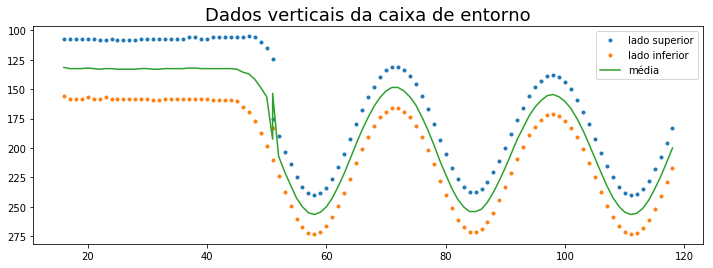

In [27]:
plt.figure(figsize=(12,4))
plt.plot(quadro, y, '.', label='lado superior')
plt.plot(quadro, y+h, '.', label='lado inferior')
plt.plot(quadro, y+h/2, '-', label='média')
plt.ylim(plt.ylim()[::-1])
plt.title('Dados verticais da caixa de entorno', fontsize=18)
plt.legend()
plt.show()

**Observação:** A diferença entre o nível dos "picos" no gráfico acima parece ser uma questão de perspectiva, devida a uma oscilação do pêndulo em um plano não exatamente paralelo à placa de captura de imagem da câmera.

### Versão completa dos dados do primeiro vídeo

Agora, não vamos exibir os vídeos, apenas capturar os dados do vídeo completo.

In [15]:
fps1, num_quadros1, tracado1 = movimento.detector_de_movimento(path.join(videos_dir, 'pendulo_70cm_1_reduzido.mov'))

#### Informações

In [16]:
print('Quadros por segundo:', fps1)
print('Número de quadros:', num_quadros1)
print(f"Tempo tratado de vídeo: {int(num_quadros1/fps1/60):3d}m {int(num_quadros1/fps1 % 60):02d}s {int(1000*(num_quadros1/fps1 % 1)):02d}ms")
print()
print('Dados iniciais do traçado:')
tracado1[1:11]

Quadros por segundo: 29.97002997002997
Número de quadros: 490
Tempo tratado de vídeo:   0m 16s 349ms

Dados iniciais do traçado:


[['quadro', 'abscissa(px)', 'ordenada(px)', 'largura(px)', 'altura(px)'],
 [16, 495, 107, 17, 49],
 [17, 494, 107, 18, 51],
 [18, 493, 107, 19, 51],
 [19, 493, 107, 19, 51],
 [20, 493, 107, 19, 50],
 [21, 493, 107, 19, 51],
 [22, 493, 108, 19, 50],
 [23, 493, 108, 19, 49],
 [24, 492, 108, 20, 50]]

#### Gráfico dos dados

Novamente, a haste do pêndulo é de $70\,\texttt{cm}$ contados da ponta de cima do fio até a centróide da bola, considerada como sendo o centro de massa do objeto, que por sua vez é tratado como um objeto pontual.

In [17]:
nd1 = np.array(tracado1[2:])
quadro1 = nd1[:,0]
x1 = nd1[:,1]
y1 = nd1[:,2]
w1 = nd1[:,3]
h1 = nd1[:,4]

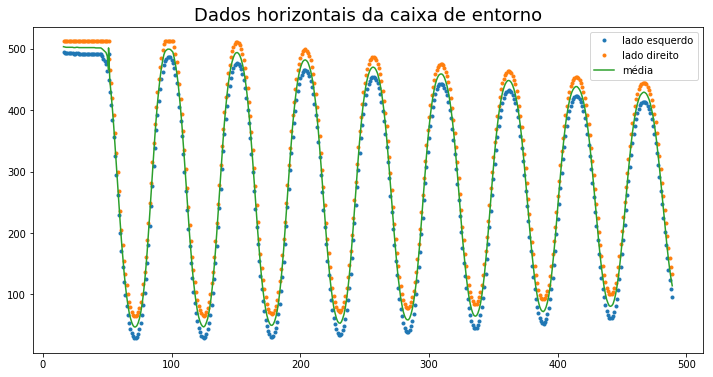

In [18]:
plt.figure(figsize=(12,6))
plt.plot(quadro1, x1, '.', label='lado esquerdo')
plt.plot(quadro1, x1+w1, '.', label='lado direito')
plt.plot(quadro1, x1+w1/2, '-', label='média')
plt.title('Dados horizontais da caixa de entorno', fontsize=18)
plt.legend()
plt.show()

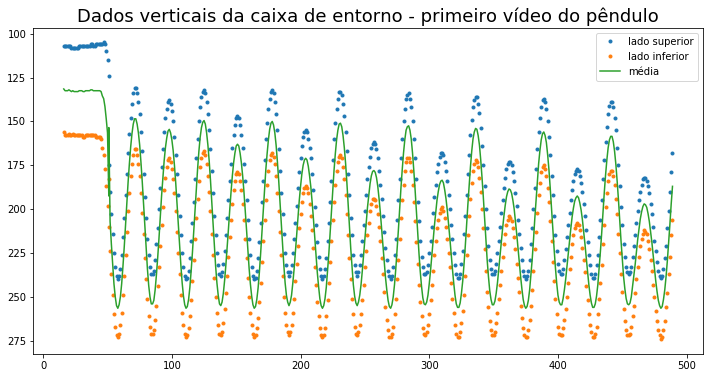

In [19]:
plt.figure(figsize=(12,6))
plt.plot(quadro1, y1, '.', label='lado superior')
plt.plot(quadro1, y1+h1, '.', label='lado inferior')
plt.plot(quadro1, y1+h1/2, '-', label='média')
plt.ylim(plt.ylim()[::-1])
plt.title('Dados verticais da caixa de entorno - primeiro vídeo do pêndulo', fontsize=18)
plt.legend()
plt.show()

**Observação:** A diferença entre o nível dos "picos" no gráfico acima parece ser uma questão de perspectiva, devida a uma oscilação do pêndulo em um plano não exatamente paralelo à placa de captura de imagem da câmera.

## Segundo vídeo do pêndulo

Novamente, o mesmo pêndulo, com os mesmo $70\,\texttt{cm}$ de haste, mas com a câmera em outra posição, um tempo maior de duração e com ângulo inicial um pouco diferente.

In [20]:
fps2, num_quadros2, tracado2 = movimento.detector_de_movimento(path.join(videos_dir, 'pendulo_70cm_2_reduzido.mov'))

In [21]:
print('Quadros por segundo:', fps2)
print('Número de quadros:', num_quadros2)
print(f"Tempo tratado de vídeo: {int(num_quadros2/fps2/60):3d}m {int(num_quadros2/fps2 % 60):02d}s {int(1000*(num_quadros2/fps2 % 1)):02d}ms")
print()
print('Dados iniciais do traçado:')
tracado2[1:11]

Quadros por segundo: 30.0
Número de quadros: 3632
Tempo tratado de vídeo:   2m 01s 66ms

Dados iniciais do traçado:


[['quadro', 'abscissa(px)', 'ordenada(px)', 'largura(px)', 'altura(px)'],
 [130, 486, 0, 26, 37],
 [131, 486, 0, 26, 47],
 [132, 484, 0, 28, 57],
 [133, 482, 0, 30, 69],
 [134, 481, 0, 31, 80],
 [135, 480, 0, 32, 89],
 [136, 480, 0, 32, 97],
 [137, 479, 0, 33, 103],
 [138, 478, 0, 34, 109]]

In [22]:
nd2 = np.array(tracado2[2:])
quadro2 = nd2[:,0]
x2 = nd2[:,1]
y2 = nd2[:,2]
w2 = nd2[:,3]
h2 = nd2[:,4]

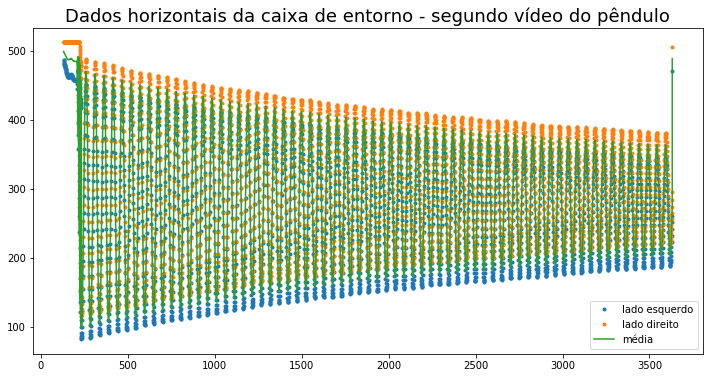

In [23]:
plt.figure(figsize=(12,6))
plt.plot(quadro2, x2, '.', label='lado esquerdo')
plt.plot(quadro2, x2+w2, '.', label='lado direito')
plt.plot(quadro2, x2+w2/2, '-', label='média')
plt.title('Dados horizontais da caixa de entorno - segundo vídeo do pêndulo', fontsize=18)
plt.legend()
plt.show()

#### Só um trecho

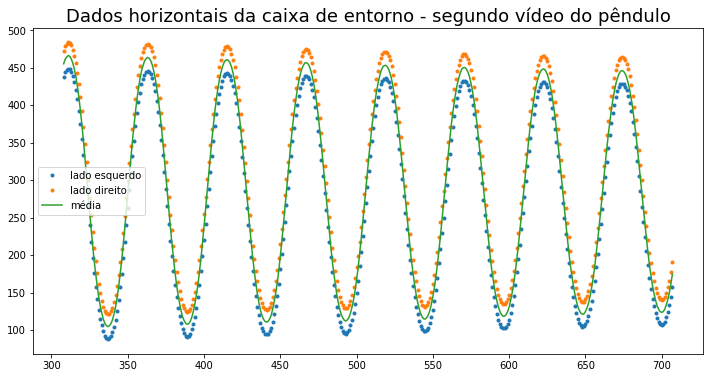

In [24]:
plt.figure(figsize=(12,6))

plt.plot(quadro2[200:600], x2[200:600], '.', label='lado esquerdo')
plt.plot(quadro2[200:600], x2[200:600]+w2[200:600], '.', label='lado direito')
plt.plot(quadro2[200:600], x2[200:600]+w2[200:600]/2, '-', label='média')
plt.title('Dados horizontais da caixa de entorno - segundo vídeo do pêndulo', fontsize=18)
plt.legend()
plt.show()

#### Só a média neste trecho

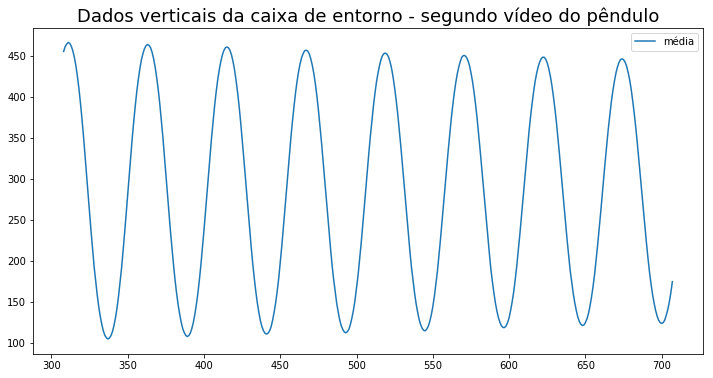

In [25]:
plt.figure(figsize=(12,6))

plt.plot(quadro2[200:600], x2[200:600]+w2[200:600]/2, '-', label='média')
plt.title('Dados verticais da caixa de entorno - segundo vídeo do pêndulo', fontsize=18)
plt.legend()
plt.show()

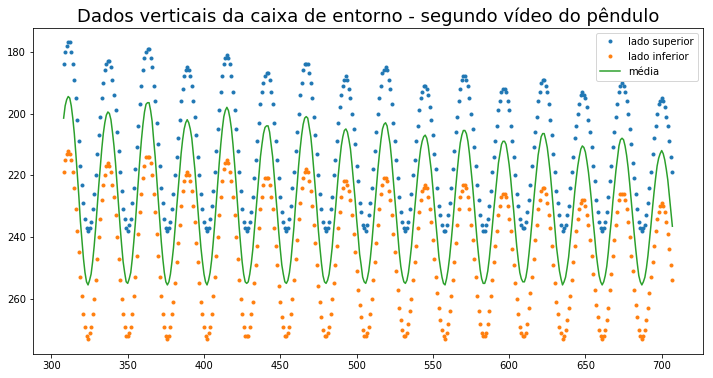

In [26]:
plt.figure(figsize=(12,6))

plt.plot(quadro2[200:600], y2[200:600], '.', label='lado superior')
plt.plot(quadro2[200:600], y2[200:600]+h2[200:600], '.', label='lado inferior')
plt.plot(quadro2[200:600], y2[200:600]+h2[200:600]/2, '-', label='média')
plt.ylim(plt.ylim()[::-1])
plt.title('Dados verticais da caixa de entorno - segundo vídeo do pêndulo', fontsize=18)
plt.legend()
plt.show()

## Sobre o ângulo

Nos vídeos, só temos a informação do comprimento da haste do pêndulo e dos pontos, em pixels, da posição e do tamanho da caixa de entorno. É preciso passar isso para o ângulo $\theta(t)$ da posição do pêndulo. Isso pode ser feito com um pouco de geometria.

## Erro de perspectiva

A câmera não está bem alinhada perpendicularmente ao plano de oscilação do pêndulo. É necessário usar uma transformação linear para ajustar esse desvio.

## Projeto

- **Objetivo:** Estender a análise do pêndulo para o caso de oscilações com grandes amplitudes, conforme discute nesta aula e na anterior. Em particular, deve conter
    
    - Um ajuste, aos dados capturados pelos vídeos acima, por um modelo de EDO incluindo um ou mais termos relativo à resistência do ar.
    
    - Analisar a dependência do período na amplitude a partir dos dados capturados pelo vídeo e comparar com a análise teórica feita na aula anterior.

- **Informações para a entrega do projeto:**
    - Enviar em arquivo no formato de um **caderno Jupyter**.

    - Enviar por correio eletrônico com cópia para Alejandro Cabrera e Ricardo Rosa.
    
    - Enviar a mensagem com o assunto **Projeto 2 de Modelagem Matemática: Pêndulo com oscilações de grande amplitude**.

    - Nomear o arquivo do caderno Jupyter com o número do projeto e o nome do(a) aluno(a), e.g. `Projeto2_Nome_do_Estudante.ipynb`.

    - Imagens ou dados que precisem ser carregados pelo caderno podem ser enviados junto com o caderno Jupyter, em um subdiretório.    
    
    - Podem enviar o caderno e o subdiretório agrupados em um único arquivo `.tar`, `.gz` ou semelhante.

- **Organização do caderno:** O caderno Jupyter deve conter as seguintes informações:

    - **Título:** "Projeto 2 de Modelagem Matemática: Pêndulo com oscilações de grande amplitude"
    - **Nome do estudande**
    - **Data de entrega**
    - **Objetivos**
    - **Descrição do projeto**
    - **Análise do problema** (incluindo dados trabalhados, métodos utilizadas, resultados obtidos, discussão dos resultados)


    

- **Data de entrega:**

    - Até terça-feira dia **30 de abril** (ou quinta-feira dia **2 de maio**?)

---

### Apresentação em slides

Para visualizar na forma de slides, abrir um "terminal" *bash* e usar a linha de comando
```bash
jupyter nbconvert 09.00-Aula9.ipynb --to slides --post serve
```

Se quiser adicionar a possibilidade de rolar a página, caso algum *slide* seja muito longo, incluir a opção
```bash
--SlidesExporter.reveal_scroll=True
```

Para usar um tema diferente do padrão, temos a configuração via `SlidesExporter.reveal_theme`. Os temas disponíveis são `beige`, `black`, `blood`, `league`, `moon`, `night`, `serif`, `simple`, `sky`, `solarized`, `white`. O padrão é `white`. Um tema interessante é
```bash
--SlidesExporter.reveal_theme=solarized
```

Para usar um efeito de transição diferente do padrão, temos a configuração via `SlidesExporter.reveal_transition`. As opções são `none`, `fade`, `slide`, `convex`, `concave` e `zoom`. O padrão é `slide`. Uma transição interessante é 
```bash
--SlidesExporter.reveal_transition=convex
```

Mais informações sobre o `nbconvert` em [Configuration options (for nbconvert)](https://nbconvert.readthedocs.io/en/latest/config_options.html) e [Present Your Data Science Projects with Jupyter Notebook Slides!](https://medium.com/learning-machine-learning/present-your-data-science-projects-with-jupyter-slides-75f20735eb0f)

<!--NAVIGATOR-->

---
[<- Aula 8: O pendulo com angulos grandes, um pouco de EDO e simulacoes](08.00-Aula8.ipynb) | [Página Inicial](00-Sumario.ipynb) 

<a href="https://colab.research.google.com/github/rmsrosa/modelagem_matematica/blob/master/aulas/09.00-Aula9.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/rmsrosa/modelagem_matematica/master?filepath=aulas/09.00-Aula9.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in binder" title="Open and Execute in Binder"></a>

<a href="https://rmsrosa.github.io/modelagem_matematica/aulas/09.00-Aula9.slides.html"><img align="left" src="https://rmsrosa.github.io/jupyterbookmaker/badges/slides_badge.svg" alt="Open slides" title="Open and View Slides"></a>
&nbsp;